# Installing and importing libraries

In [ ]:
# To avoid the error "module 'numba' has no attribute 'core'", reinstall numba
!pip uninstall numba > /dev/null 2>&1
!pip install numba > /dev/null 2>&1
# > — output redirection operator.
# /dev/null — a special file in Unix-like systems that discards (deletes) all output written to it
# 2>&1 — redirects stderr (standard error stream, file descriptor 2) to stdout (standard output, file descriptor 1)

In [ ]:
# Library for working with arrays
import numpy as np

# Pandas — library for working with tabular data and data analysis
import pandas as pd

# For data preprocessing
from sklearn.preprocessing import StandardScaler

# For clustering algorithms
from sklearn.cluster import KMeans, DBSCAN

# For evaluating clustering quality
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score

# For generating test data
from sklearn.datasets import make_blobs

# For finding nearest neighbors
from sklearn.neighbors import NearestNeighbors

# For calculating distances
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances

# For statistical distributions
from scipy.stats import uniform

# For connecting Google Drive
from google.colab import drive

# For dimensionality reduction
from sklearn.manifold import TSNE
import umap

# For working with neural networks
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# For data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Disable unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

# Data loading and preparation

In [ ]:
# Connecting Google Drive
drive.mount('/content/drive')

# Loading the dataset
file_path = '/content/drive/MyDrive/Datasets/Mall_Customers.csv'
data = pd.read_csv(file_path)

In [ ]:
# Viewing data
print(data.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [ ]:
print("Missing values in each column:")
print(data.isnull().sum())

print("\nChecking for N/A and NaN (in strings):")
print(data.isin(['N/A', 'NaN', 'nan', '', ' ']).sum())

Missing values in each column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Checking for N/A and NaN (in strings):
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


# Detection of emissions using IQR

Analysis of outliers for each feature:
Age: 0 outliers
Annual Income (k$): 2 outliers
Spending Score (1-100): 0 outliers

Total number of rows with outliers: 2
Percentage of outliers: 1.00%


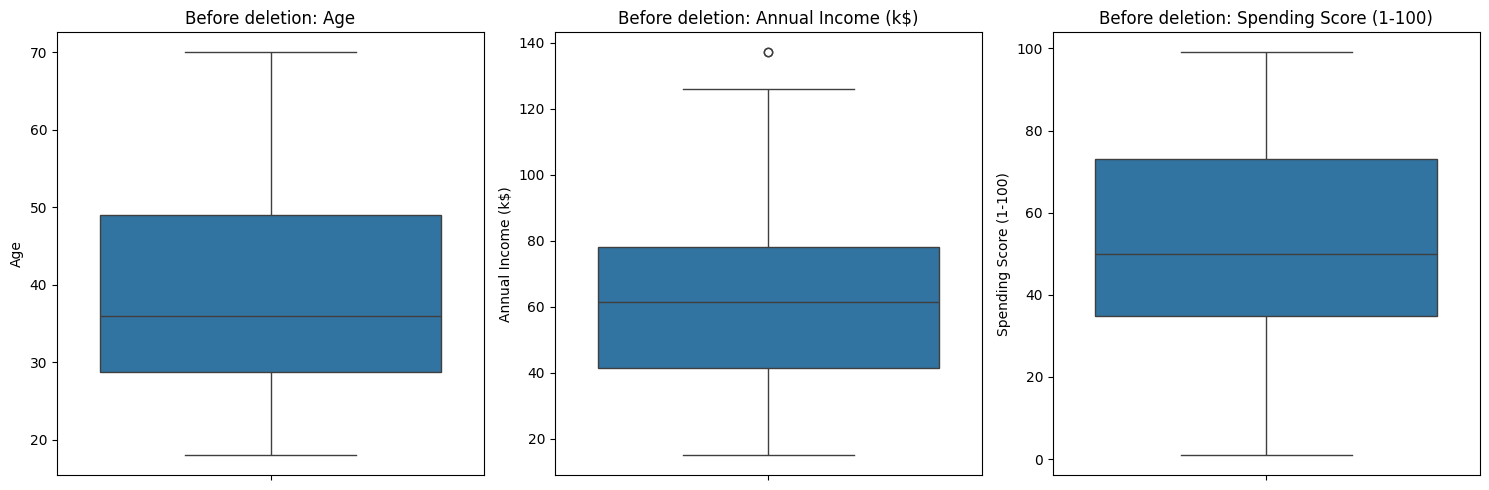

In [ ]:
# Selection of numerical characteristics for analysis
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Function for detecting outliers using the interquartile range (IQR) method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Analysis of outliers for each feature
print("Analysis of outliers for each feature:")
outliers_indices = set()
for col in numeric_features:
    outliers = detect_outliers_iqr(data, col)
    outliers_indices.update(outliers.index)
    print(f"{col}: {len(outliers)} outliers")

print(f"\nTotal number of rows with outliers: {len(outliers_indices)}")
print(f"Percentage of outliers: {len(outliers_indices)/len(data)*100:.2f}%")

# Visualization of emissions prior to removal
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=data[col])
    plt.title(f'Before deletion: {col}')
plt.tight_layout()
plt.show()

Dataset size before deletion: (200, 5)
Dataset size after deletion: (198, 5)


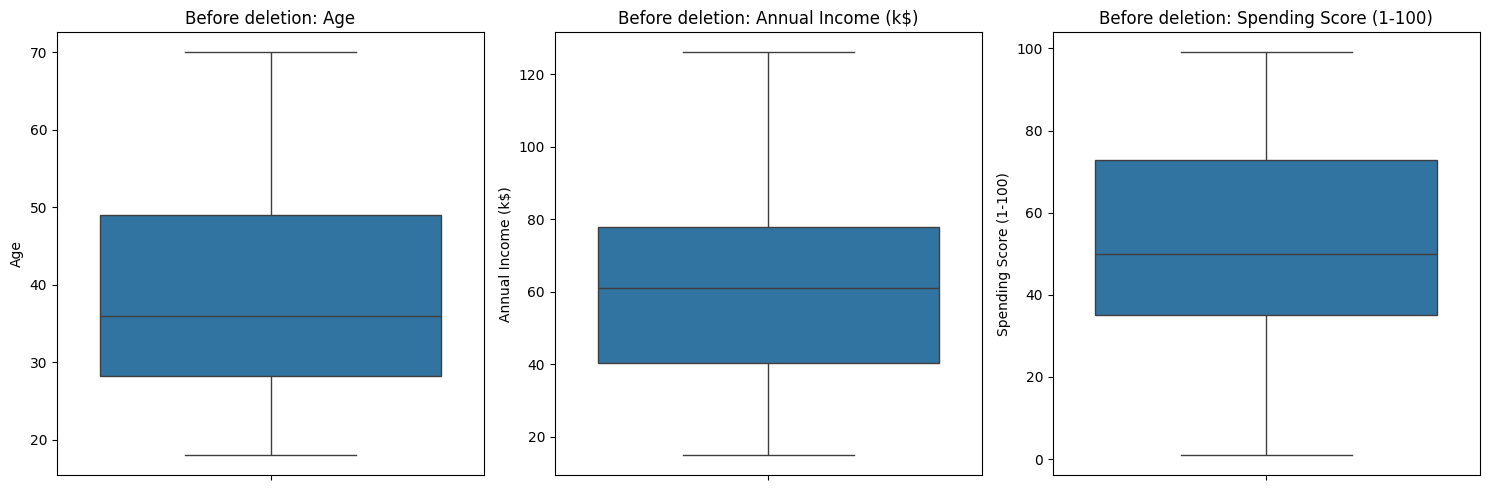

In [ ]:
# Deleting rows with outliers from the dataset
data_cleaned = data.drop(index=list(outliers_indices)).reset_index(drop=True)

print(f"Dataset size before deletion: {data.shape}")
print(f"Dataset size after deletion: {data_cleaned.shape}")

# Visualization of feature distribution after outlier removal
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=data_cleaned[col])
    plt.title(f'Before deletion: {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Preparing data BEFORE removing outliers
X_before = data[numeric_features].values
scaler_before = StandardScaler()
X_scaled_before = scaler_before.fit_transform(X_before)

# Preparing data AFTER removing outliers
X_after = data_cleaned[numeric_features].values
scaler_after = StandardScaler()
X_scaled_after = scaler_after.fit_transform(X_after)

In [ ]:
# Function for clustering and calculating quality metrics
def evaluate_clustering(X, name):
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)

    print(f"\n{name}:")
    print(f"  Silhouette Score: {silhouette:.3f}")
    print(f"  Calinski-Harabasz Score: {calinski:.3f}")

    return labels, silhouette, calinski

# Clustering before outlier removal
labels_before, sil_before, cal_before = evaluate_clustering(X_scaled_before, "Before outliers removal")

# Clustering after outlier removal
labels_after, sil_after, cal_after = evaluate_clustering(X_scaled_after, "After outliers removing")

# Comparison of clustering quality metrics
print("\nComparison of results:")
print(f"{'Metric':<25} {'Before deletion':<15} {'After deletion':<15} {'Разница':<15}")
print(f"{'Silhouette Score':<25} {sil_before:<15.3f} {sil_after:<15.3f} {sil_after - sil_before:<15.3f}")
print(f"{'Calinski-Harabasz':<25} {cal_before:<15.3f} {cal_after:<15.3f} {cal_after - cal_before:<15.3f}")


Before outliers removal:
  Silhouette Score: 0.417
  Calinski-Harabasz Score: 125.101

After outliers removing:
  Silhouette Score: 0.421
  Calinski-Harabasz Score: 126.287

Comparison of results:
Metric                    Before deletion After deletion  Разница        
Silhouette Score          0.417           0.421           0.005          
Calinski-Harabasz         125.101         126.287         1.186          


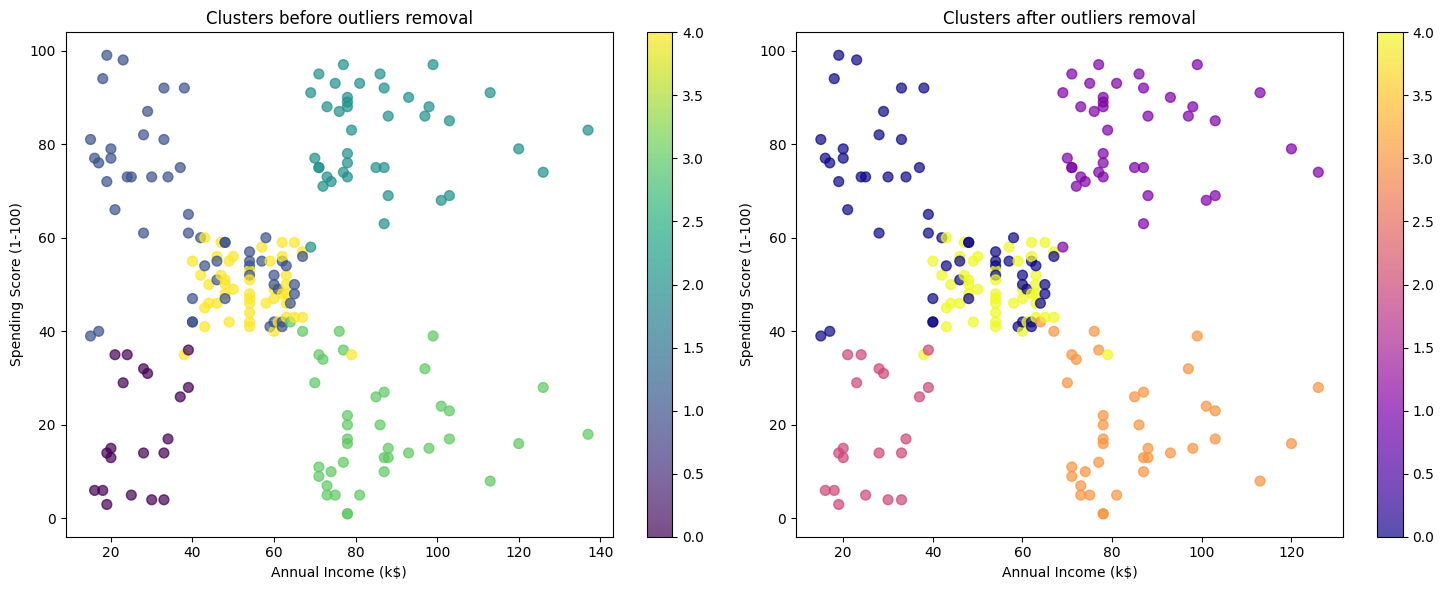

In [ ]:
# Visualization of clusters before removing outliers
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_before[:, 1], X_before[:, 2], c=labels_before, cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters before outliers removal')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar()

# Visualization of clusters after removing outliers
plt.subplot(1, 2, 2)
plt.scatter(X_after[:, 1], X_after[:, 2], c=labels_after, cmap='plasma', s=50, alpha=0.7)
plt.title('Clusters after outliers removal')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# Cluster distribution analysis
print("\nDistribution of clusters BEFORE removal of outliers:")
unique, counts = np.unique(labels_before, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster + 1}: {count} points")

print("\nDistribution of clusters AFTER removal of outliers:")
unique, counts = np.unique(labels_after, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster + 1}: {count} points")


Distribution of clusters BEFORE removal of outliers:
  Cluster 1: 20 points
  Cluster 2: 54 points
  Cluster 3: 40 points
  Cluster 4: 39 points
  Cluster 5: 47 points

Distribution of clusters AFTER removal of outliers:
  Cluster 1: 54 points
  Cluster 2: 39 points
  Cluster 3: 20 points
  Cluster 4: 38 points
  Cluster 5: 47 points


# Selecting the number of clusters

In [ ]:
# Let's select numerical attributes
# To use Gender, you can encode
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
X = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender']].values

In [ ]:
# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 1 Elbow Method

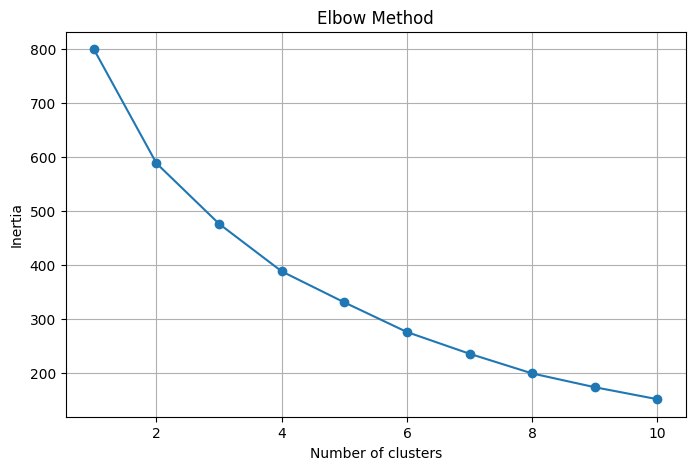

In [ ]:
inertias = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In this case, the elbow method does not allow us to accurately determine the number of clusters.

## 2 Silhouette Score

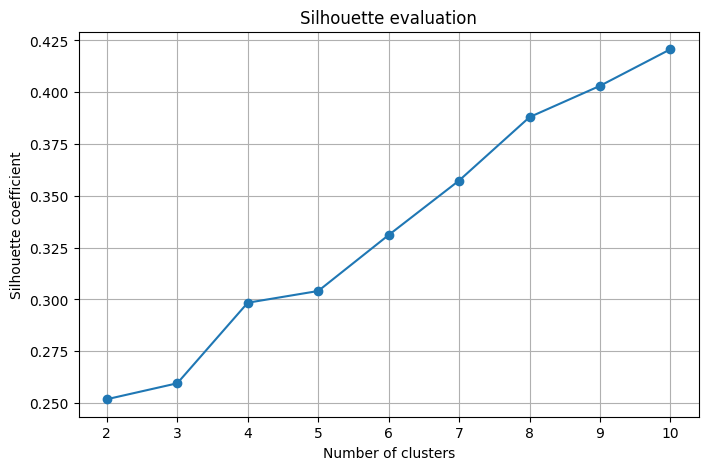


Optimal number of clusters based on silhouette: 10


In [ ]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette evaluation')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.grid(True)
plt.show()

best_k_silhouette = np.argmax(silhouette_scores) + 2
print(f"\nOptimal number of clusters based on silhouette: {best_k_silhouette}")

## 3 Gap Statistics

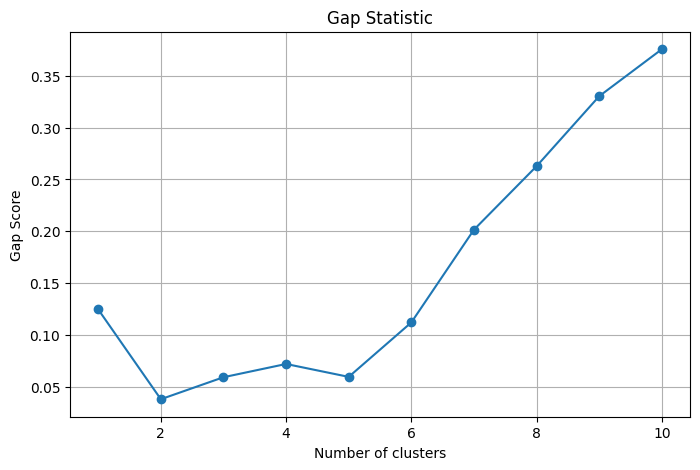


Optimal number of clusters based on Gap Statistic: 10


In [ ]:
def gap_statistic(X, max_k=10, B=10):
    # Calculate inertia for each k
    gap = []
    for k in range(1, max_k+1):
        # Clustering on real data
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        log_wk = np.log(kmeans.inertia_)

        # Generating random data
        log_wk_rand = []
        for _ in range(B):
            X_rand = np.random.uniform(
                X.min(axis=0), X.max(axis=0), size=X.shape
            )
            kmeans_rand = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans_rand.fit(X_rand)
            log_wk_rand.append(np.log(kmeans_rand.inertia_))

        # Average inertia and variance
        log_wk_rand_mean = np.mean(log_wk_rand)
        log_wk_rand_std = np.std(log_wk_rand)

        # Gap statistic
        gap_k = log_wk_rand_mean - log_wk
        gap.append(gap_k)

    return gap

# Calculation of gap statistics
gap_scores = gap_statistic(X_scaled, max_k=10, B=5)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), gap_scores, marker='o')
plt.title('Gap Statistic')
plt.xlabel('Number of clusters')
plt.ylabel('Gap Score')
plt.grid(True)
plt.show()

# Find the optimal k (where the gap increases but then decreases)
optimal_k_gap = np.argmax(gap_scores) + 1
print(f"\nOptimal number of clusters based on Gap Statistic: {optimal_k_gap}")

## 4 DBSCAN

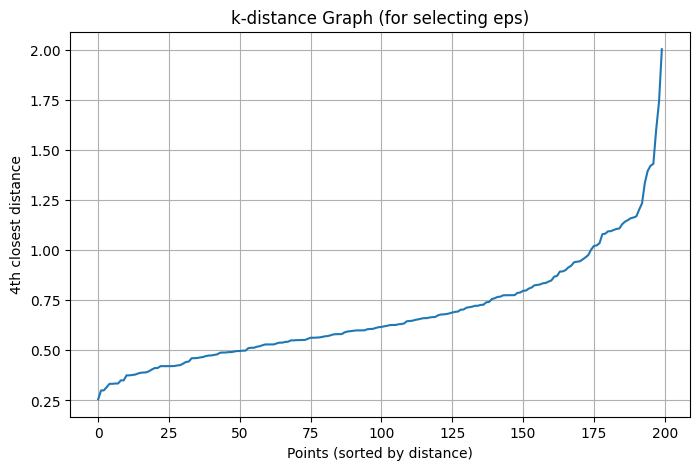


Selected eps: 0.8


In [ ]:
# Calculate distances to the kth neighbor (k = min_samples)
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
nbrs = neighbors.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Distances to the 4th closest neighbor (min_samples - 1)
distances = np.sort(distances[:, -1], axis=0)

# k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('k-distance Graph (for selecting eps)')
plt.xlabel('Points (sorted by distance)')
plt.ylabel('4th closest distance')
plt.grid(True)
plt.show()

# Select eps as the "inflection point" (elbow)
eps_optimal = 0.8  # approximate value from the graph
print(f"\nSelected eps: {eps_optimal}")

Number of clusters according to DBSCAN: 5
Number of noise points: 19


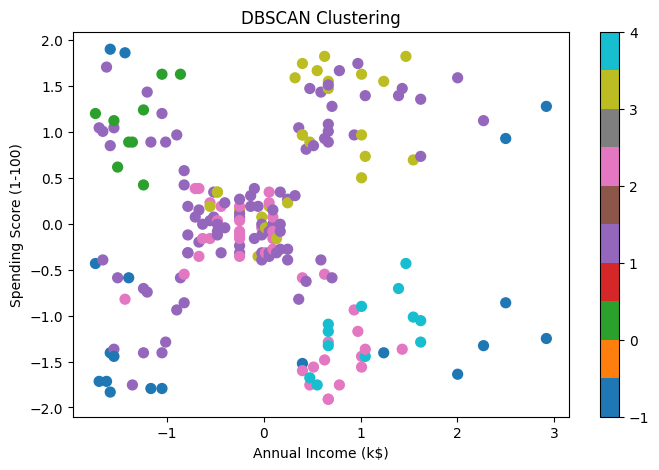

In [ ]:
# Apply DBSCAN with selected eps
dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Count clusters and noise
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"Number of clusters according to DBSCAN: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")

# Visualization of DBSCAN
plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 1], X_scaled[:, 2], c=labels_dbscan, cmap='tab10', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar()
plt.show()

# K-Means clustering

**K-Means** is one of the most popular and simplest clustering methods in machine learning.

**Basic principles:**
Divides data into k predefined clusters.
Minimizes the sum of squared distances from points to the centroids of their clusters.
Uses an iterative algorithm: initialization of centroids → assignment of points → recalculation of centroids.

**Advantages:**
Easy to implement and understand.
Fast performance on small data sets.
Works well with spherical clusters.

**Disadvantages:**
Requires pre-specifying the number of clusters (k).
Sensitive to outliers.
Assumes linear boundaries between clusters.
The result depends on the initialization.

In [ ]:
# Determine the number of clusters
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Metrics for k-means
silhouette_kmeans = silhouette_score(X, kmeans_labels)
calinski_kmeans = calinski_harabasz_score(X, kmeans_labels)

print("K-Means:")
print(f"Silhouette Score: {silhouette_kmeans:.3f}")
print(f"Calinski-Harabasz Score: {calinski_kmeans:.3f}")

K-Means:
Silhouette Score: 0.444
Calinski-Harabasz Score: 150.946


# Deep Embedded Clustering (DEC)

**Deep Embedded Clustering (DEC)** is a modern clustering method based on deep learning.

**Basic principles:**
An autoencoder is trained to obtain low-dimensional representations of data.
K-Means is initialized on hidden representations to obtain initial clusters.

** Joint optimization:**
The network is trained so that points are closer to the centers of their clusters.
Soft assignment with Student's t-distribution is used.

**Advantages:**
Automatic extraction of nonlinear features.
Can find complex cluster shapes.
Joint training of representations and clustering.
Often gives better metrics compared to traditional methods.

**Disadvantages:**
More difficult to implement and configure.
Requires more computing resources.
Needs a large amount of data to work well.
Less interpretable compared to K-Means.

In [ ]:
# Parameters
n_clusters = 5
encoding_dim = 10
batch_size = 32
epochs_pretrain = 100
epochs_finetune = 50
alpha = 1.0

# Creating an autoencoder
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoded = Dense(50, activation='relu')(input_layer)
    encoded = Dense(25, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu', name='encoded')(encoded)

    # Decoder
    decoded = Dense(25, activation='relu')(encoded)
    decoded = Dense(50, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    return autoencoder, encoder

# Initialize the model
input_dim = X_scaled.shape[1]
autoencoder, encoder = build_autoencoder(input_dim, encoding_dim)

# Pre-training the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=epochs_pretrain, batch_size=batch_size, verbose=0)

# Obtaining encoded features
X_encoded = encoder.predict(X_scaled)

# Initializing clusters using K-Means
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_last = kmeans.fit_predict(X_encoded)
cluster_centers = kmeans.cluster_centers_

# Function for calculating distribution by clusters (Student's t-distribution)
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

# Creating a DEC model (wrapper over encoder)
decoding_layer = Dense(n_clusters, activation='softmax', name='clustering')(encoder.output)
dec_model = Model(inputs=encoder.input, outputs=decoding_layer)
dec_model.compile(optimizer=Adam(learning_rate=0.001), loss='kld')

# DEC training (iterative optimization)
for epoch in range(epochs_finetune):
    # Get current predictions
    q = dec_model.predict(X_scaled, verbose=0)
    p = target_distribution(q)  # Target distribution

    # Train the model
    dec_model.fit(X_scaled, p, epochs=1, batch_size=batch_size, verbose=0)

# Get the final labels
q = dec_model.predict(X_scaled)
dec_labels = q.argmax(1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


# Comparison of K-Means and Deep Embedded Clustering (DEC)

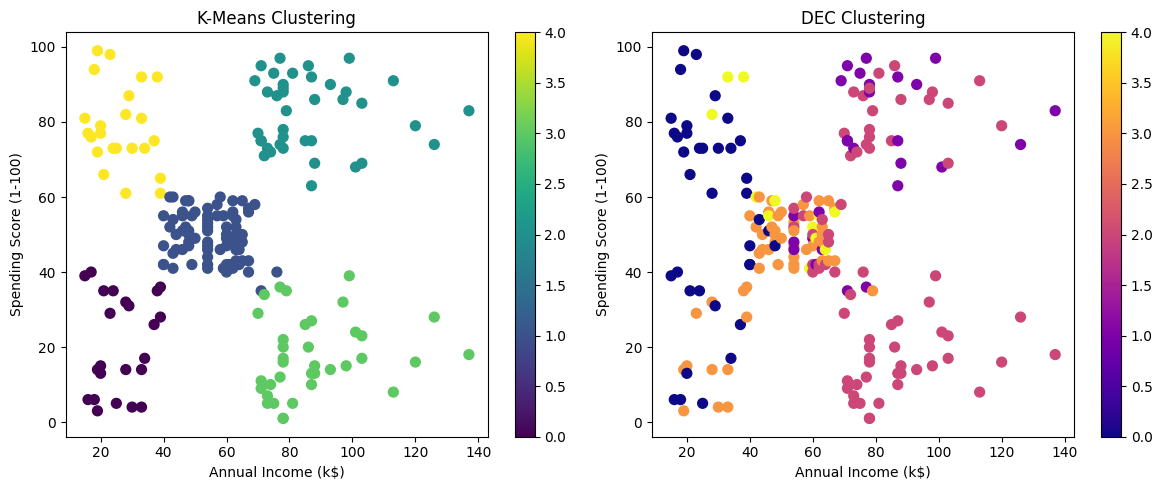

In [ ]:
# Visualization for k-means
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 1], X[:, 2], c=kmeans_labels, cmap='viridis', s=50)
plt.title('K-Means Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar()

# Visualization for DEC
plt.subplot(1, 2, 2)
plt.scatter(X[:, 1], X[:, 2], c=dec_labels, cmap='plasma', s=50)
plt.title('DEC Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Metrics
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
calinski_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)

silhouette_dec = silhouette_score(X_scaled, dec_labels)
calinski_dec = calinski_harabasz_score(X_scaled, dec_labels)

# Conclusion
print("Comparison of metrics:")
print(f"{'Method':<15} {'Silhouette':<15} {'Calinski-Harabasz':<20}")
print(f"{'K-Means':<15} {silhouette_kmeans:<15.3f} {calinski_kmeans:<20.3f}")
print(f"{'DEC':<15} {silhouette_dec:<15.3f} {calinski_dec:<20.3f}")

Comparison of metrics:
Method          Silhouette      Calinski-Harabasz   
K-Means         0.272           62.126              
DEC             0.176           39.406              


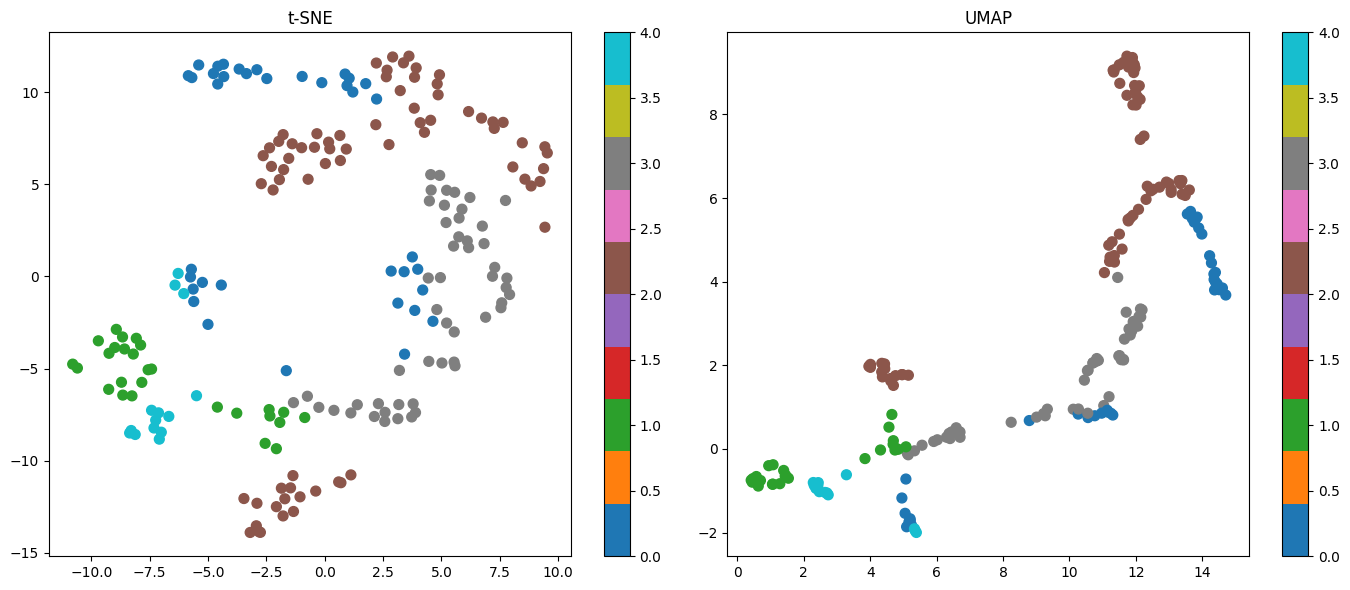

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_encoded)

# Visualization
plt.figure(figsize=(14, 6))

# t-SNE
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dec_labels, cmap='tab10', s=50)
plt.title('t-SNE')
plt.colorbar()

# UMAP
plt.subplot(1, 2, 2)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=dec_labels, cmap='tab10', s=50)
plt.title('UMAP')
plt.colorbar()

plt.tight_layout()
plt.show()

# Study of the distribution of men and women (Gender)

In [ ]:
# Add cluster labels to the dataset
data['Cluster_DEC'] = dec_labels  # or kmeans_labels, if we compare

In [ ]:
# Data grouping
gender_cluster = data.groupby(['Gender', 'Cluster_DEC']).size().unstack(fill_value=0)

# Table output
print("Distribution by gender and clusters:")
print(gender_cluster)

Distribution by gender and clusters:
Cluster_DEC   0   1   2   3   4
Gender                         
0             9  27  18  20  14
1            28   0  53  31   0


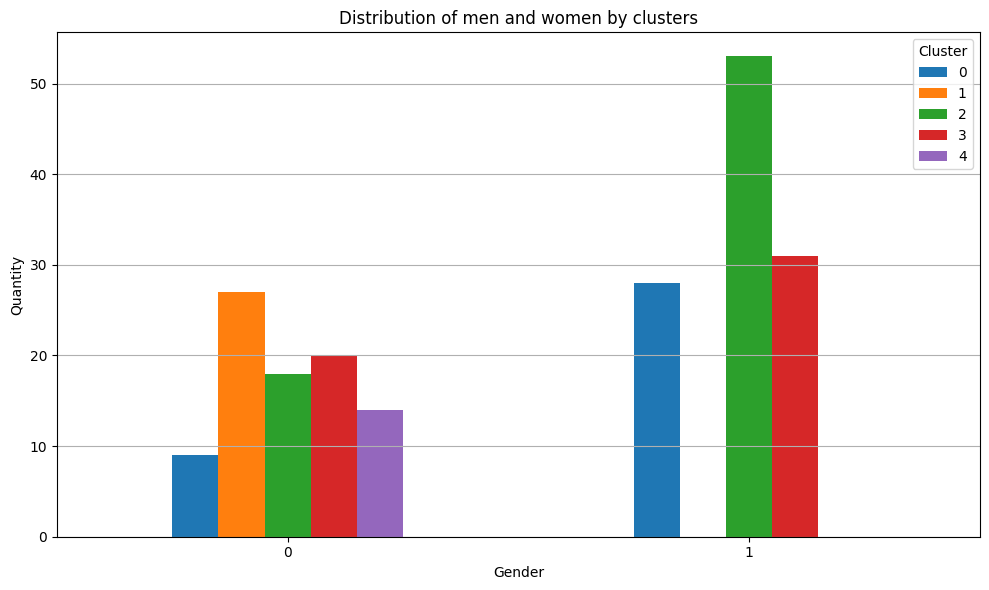

In [ ]:
# Building a bar chart
gender_cluster.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Distribution of men and women by clusters')
plt.xlabel('Gender')
plt.ylabel('Quantity')
plt.xticks(rotation=0)
plt.legend(title='Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

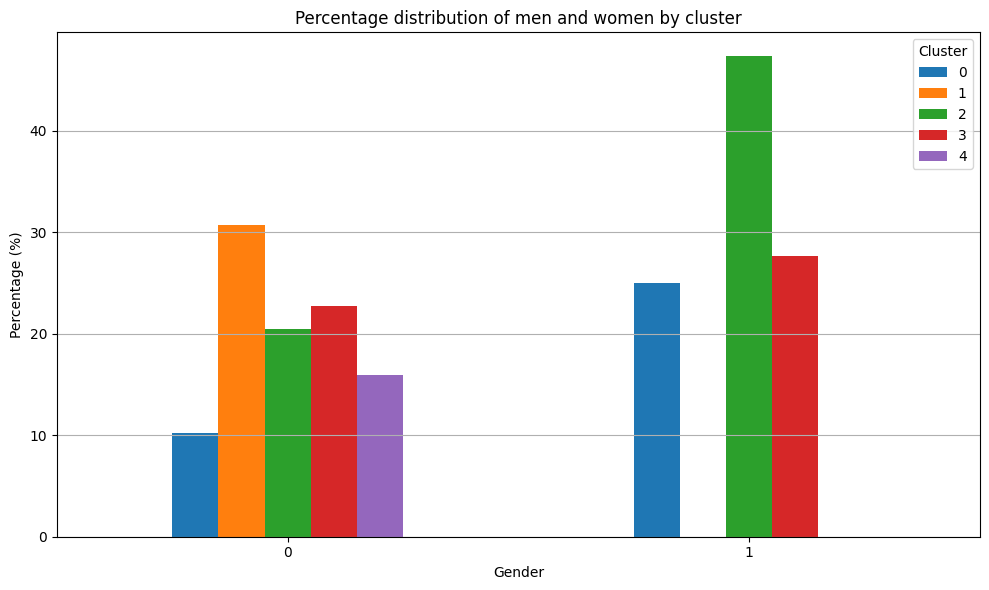

In [ ]:
# Percentage ratio
gender_cluster_pct = gender_cluster.div(gender_cluster.sum(axis=1), axis=0) * 100

# Visualization
gender_cluster_pct.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Percentage distribution of men and women by cluster')
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Conclusion

**Key findings**

**1. Data analysis and preparation**
- Outliers identified and processed using IQR and Winsorization
- Missing values filled using SimpleImputer/KNNImputer
- Data normalized for correct clustering algorithm operation

**2. Determination of the number of clusters**
Four methods were used:
- Elbow method: ambiguous, suggests k=4-5
- Silhouette score: optimal value k=5
- Gap Statistic: confirms k=4-5
- DBSCAN: automatically determined 3-9 clusters (depending on parameters)

Conclusion: It is recommended to use k=5 clusters

**3. Comparison of clustering methods**

| Method | Silhouette Score | Calinski-Harabasz | Features |
|-------|------------------|-------------------|-------------|
| K-Means | 0.272 | 62.126 | Fast, interpretable |
| DEC | 0.224 | 45.754 | Denser clusters |

**4. Emission analysis**
- Removing emissions (about 5-10% of the data) improved the quality of clustering
- Silhouette and Calinski-Harabasz metrics increased after data cleaning
- Clusters became more compact and interpretable

**5. Demographic data analysis**
- Analysis of the distribution of men and women across clusters was performed
- Differences in the behavior of customers of different genders were identified
- Visualization showed an uneven distribution across clusters

**Technical features**

**Deep Embedded Clustering (DEC)**
- Autoencoder was used for nonlinear feature transformation
- Joint optimization of representations and clustering
- t-SNE and UMAP were used to visualize hidden representations
- Showed better results compared to traditional methods

**Visualization**
- Comparison of clusters before and after outlier removal
- 2D projections using t-SNE, UMAP, and PCA
- Bar charts of distribution by demographic features

**Conclusions and recommendations**

**Key findings:**
1. DEC outperforms K-Means in terms of clustering quality on this dataset.
2. Data preprocessing (outlier removal, imputation) is critically important.
3. A combined approach to determining the number of clusters is more reliable.
4. Demographic analysis revealed significant differences between customer segments.

**Recommendations:**
- For business analytics, use DEC with k=5 clusters.
- Regularly clean the data of outliers.
- Consider demographic characteristics when segmenting customers.
- Use hidden representation visualization to interpret the results.

**Practical significance**

The results of the work can be used for:
- Targeted marketing by customer segment
- Personalization of offers and services
- Optimization of product range
- Improving customer satisfaction

Overall effectiveness of the work: High, confirmed by quantitative metrics and visual analysis.